# African Jets

This tutorial creates a representation of the African Jets over the Sahel.

These jets are:

- Tropcial Easterly Jet (at around 200 hPa)
- African Easterly Jet (at around 600 hPa)
- African Easterly Waves (between)


In [6]:
import numpy as np
import geoutils.plotting.plots as gplt
import geoutils.geodata.base_dataset as bds
import geoutils.utils.time_utils as tu
import geoutils.tsa.time_series_analysis as tsa
import geoutils.tsa.propagation as prop
import geoutils.tsa.pca.eof as eof
import geoutils.tsa.pca.multivariate_pca as mvpca
import geoutils.utils.general_utils as gut
import geoutils.geodata.wind_dataset as wds
import geoutils.utils.met_utils as mut
import geoutils.utils.spatial_utils as sput

from importlib import reload
output_dir = "/home/strnad/data/"
data_dir = "/home/strnad/data/"
plot_dir = "/home/strnad/data/plots/african_jets/"

In [2]:
# Load data
grid_step = 2.5
# Load wind fields
reload(wds)
nc_files_u = []
nc_files_v = []
nc_files_w = []
levs = [200, 600]
levs = np.arange(100, 1050, 100)
for lev in levs:
    dataset_file_u = data_dir + \
        f"/climate_data/{grid_step}/era5_u_{grid_step}_{lev}_ds.nc"
    nc_files_u.append(dataset_file_u)
    dataset_file_v = data_dir + \
        f"/climate_data/{grid_step}/era5_v_{grid_step}_{lev}_ds.nc"
    nc_files_v.append(dataset_file_v)
    dataset_file_w = data_dir + \
        f"/climate_data/{grid_step}/era5_w_{grid_step}_{lev}_ds.nc"
    nc_files_w.append(dataset_file_w)

reload(wds)
ds_wind = wds.Wind_Dataset(data_nc_u=nc_files_u,
                           #    data_nc_v=nc_files_v,
                           #    data_nc_w=nc_files_w,
                           plevels=levs,
                           can=True,
                           an_types=['month'],
                           month_range=['Jul', 'Aug'],
                           init_mask=False,
                           grid_step=grid_step,
                           verbose=False
                           )

Time steps within 1979-01-01 to 2019-12-31 selected!
Interpolte grid from -180.0 to 177.5, -90.0 to 90.0!
Loaded Pressure levels [ 100  200  300  400  500  600  700  800  900 1000] as dimension lev!
Only u component available!
Set variable name to u!
Compute anomalies u_an_month
Created monthly anomalies!
Rename u to u_an_month!


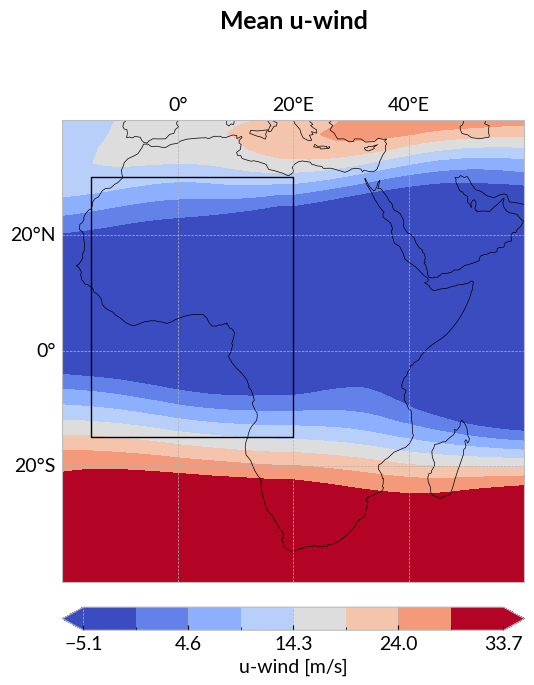

In [40]:
reload(mut)
sahel_lon_range = [-15, 20]  # Along this line is the vertical cross section
sahel_lat_range = [-15, 30]

im = gplt.plot_map(ds_wind.ds['u'].sel(lev=200).mean(dim='time'),
                   title='Mean u-wind',
                   lon_range=[-20, 60],
                   lat_range=[-40, 40],
                   label='u-wind [m/s]',
                   )
im = gplt.plot_rectangle(ax=im['ax'],
                         lon_range=sahel_lon_range,
                         lat_range=sahel_lat_range,)

In [43]:
var_name = 'u'
cross_data_av = mut.vertical_cross_section_average(ds_wind.ds[var_name],
                                                   lon_range=sahel_lon_range,
                                                   lat_range=sahel_lat_range,)

In [4]:
cross_data_line = mut.vertical_cross_section(data=ds_wind.ds[var_name],
                                             lon_range=sahel_lon_range,
                                             lat_range=sahel_lat_range)

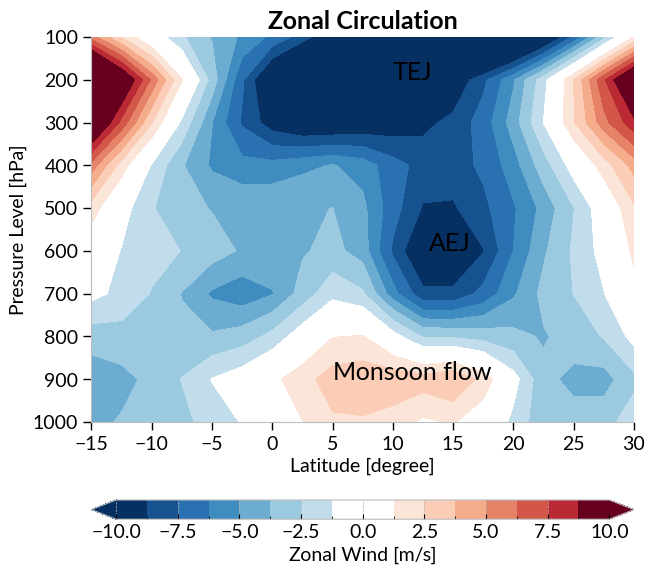

In [44]:
reload(gplt)
reload(gplt.cmpl)
lats = cross_data_av['lat']
plevels = cross_data_av.lev
label_u = 'Zonal Wind [m/s]'
h_im_u = gplt.plot_2D(x=lats, y=plevels,
                      z=cross_data_av.mean(dim='time'),
                      levels=16,
                      title='Zonal Circulation',
                      cmap='RdBu_r',
                      centercolor='white',
                      plot_type='contourf',
                      extend='both',
                      xlabel='Latitude [degree]',
                      ylabel='Pressure Level [hPa]',
                      flip_y=True,
                      label=label_u,
                      vmin=-10, vmax=10,
                      pad=-5,
                      ylim=[100, 1000],
                      )

gplt.plt_text(ax=h_im_u['ax'],
              text='TEJ',
              xpos=10,
              ypos=200)
_ = gplt.plt_text(ax=h_im_u['ax'],
                  text='AEJ',
                  xpos=13,
                  ypos=600)
_ = gplt.plt_text(ax=h_im_u['ax'],
                  text='Monsoon flow',
                  xpos=5,
                  ypos=900)
savepath = plot_dir +\
    f"/climatology.png"
gplt.save_fig(savepath, fig=h_im_u['fig'])

## PCA of Jets in Africa


Explained variance: 0.6102688312530518 by 5 EOFs


'Explained variance: 0.6102688312530518 by 5 EOFs'

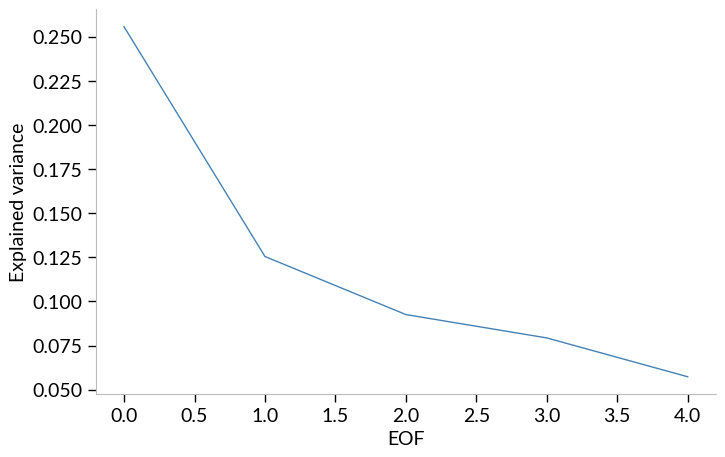

In [32]:
input_data = cross_data_av
reload(eof)
n_components = 5
sppca = eof.SpatioTemporalPCA(input_data, n_components=n_components)
eofs = sppca.get_eofs()
reofs = sppca.eofs_real_space()
pcs = sppca.get_principal_components()
im = gplt.plot_xy(y_arr=sppca.explained_variance(),
                  xlabel='EOF', ylabel='Explained variance',
                  ylog=False)
gut.myprint(
    f"Explained variance: {np.sum(sppca.explained_variance())} by {n_components} EOFs")

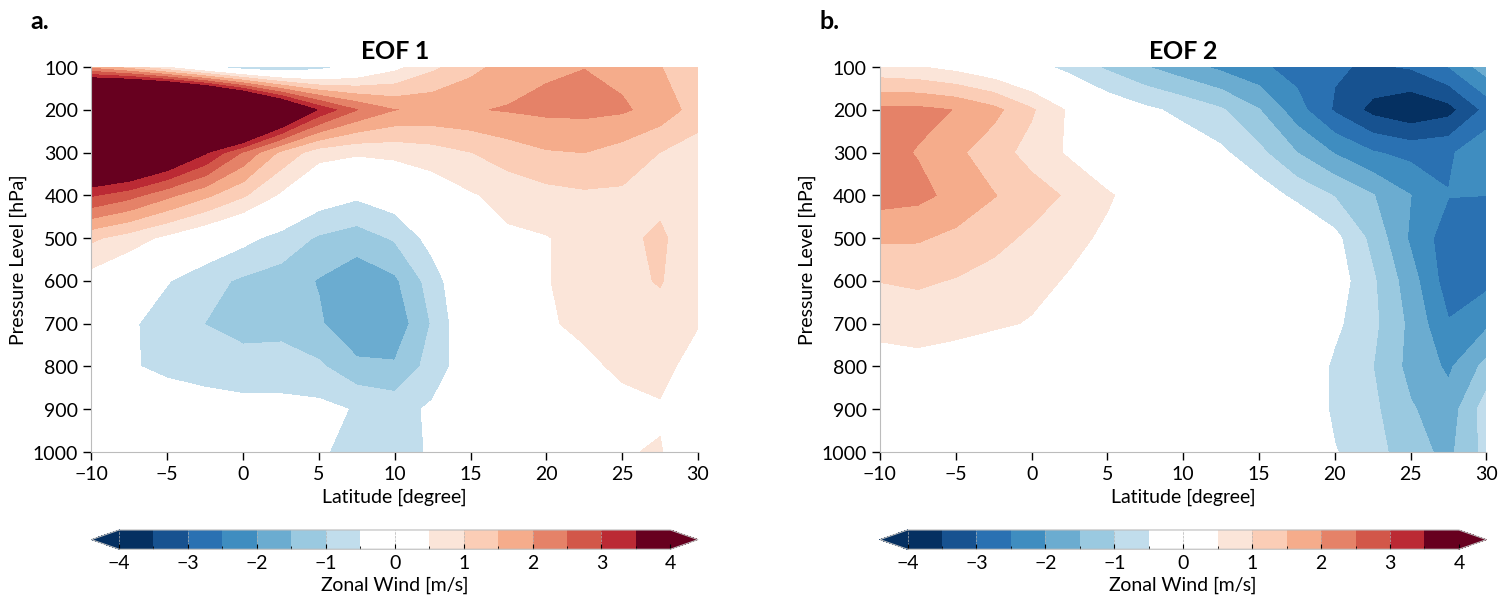

In [34]:
reload(gplt)
i = 0
ncols = 2
im = gplt.create_multi_plot(nrows=1, ncols=ncols,
                            wspace=0.3,
                            )

for i in range(2):
    im_eof = gplt.plot_2D(x=lats, y=plevels,
                          ax=im['ax'][i],
                          z=reofs.isel(eof=i),
                          levels=16,
                          title=f'EOF {i+1}',
                          cmap='RdBu_r',
                          centercolor='white',
                          plot_type='contourf',
                          extend='both',
                          xlabel='Latitude [degree]',
                          ylabel='Pressure Level [hPa]',
                          flip_y=True,
                          label=label_u,
                          vmin=-4, vmax=4,
                          pad=-5,
                          ylim=[100, 1000],
                          )
savepath = plot_dir +\
    f"/first_eofs.png"
gplt.save_fig(savepath, fig=im['fig'])